# Overall benchmark analysis

This notebook contains analysis of the overall benchmark data for scCODA.
Mainly, the code to reproduce all plots from the paper is shown.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import re
import shutil
import pickle as pkl

sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

In [2]:
results_path = "../../zenodo_data_rv1/sccoda_benchmark_data/overall_benchmark/"

In [3]:
# Join all together
res = pd.read_csv(results_path + "benchmark_results_fdr_005", index_col=0)

print(res)

     n_cell_types  n_cells  n_controls  n_cases  Base  Increase  \
0               5     5000           2        9    20        80   
1               5     5000           2        9    20        80   
2               5     5000           2        9    20        80   
3               5     5000           2        9    20        80   
4               5     5000           2        9    20        80   
..            ...      ...         ...      ...   ...       ...   
495             5     5000           8        8    30        70   
496             5     5000           8        8    30        70   
497             5     5000           8        8    30        70   
498             5     5000           8        8    30        70   
499             5     5000           8        8    30        70   

     log-fold increase                                b_true  \
0                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
1                 2.32  [-5.521 -1.39  -1.39  -1.39  -1.39 ]   
2  

First off, heatmaps:

First, we look at a grid of heatmaps for all combinations of base and increase.
Each heatmap shows the performance of scCODA over all combinations of number of control and effected samples.
We can see that with increasing absolute effect size, as well as for cell types that are generally more rare,
the performance of scCODA increases.
This shows that scCODA's performance depends on the absolute, as well as the relative effect.

Also, we can see that for higher sample sizes, scCODA often achieves better results,
especially for effects that are not easy or almost impossible to identify.
Hereby, the individual heatmaps show no bias towards one group (control or case samples),
and also the lower sample size in both groubs seems to be the driving factor in the performance

These trends are analyzed quantitatively in the power analysis.

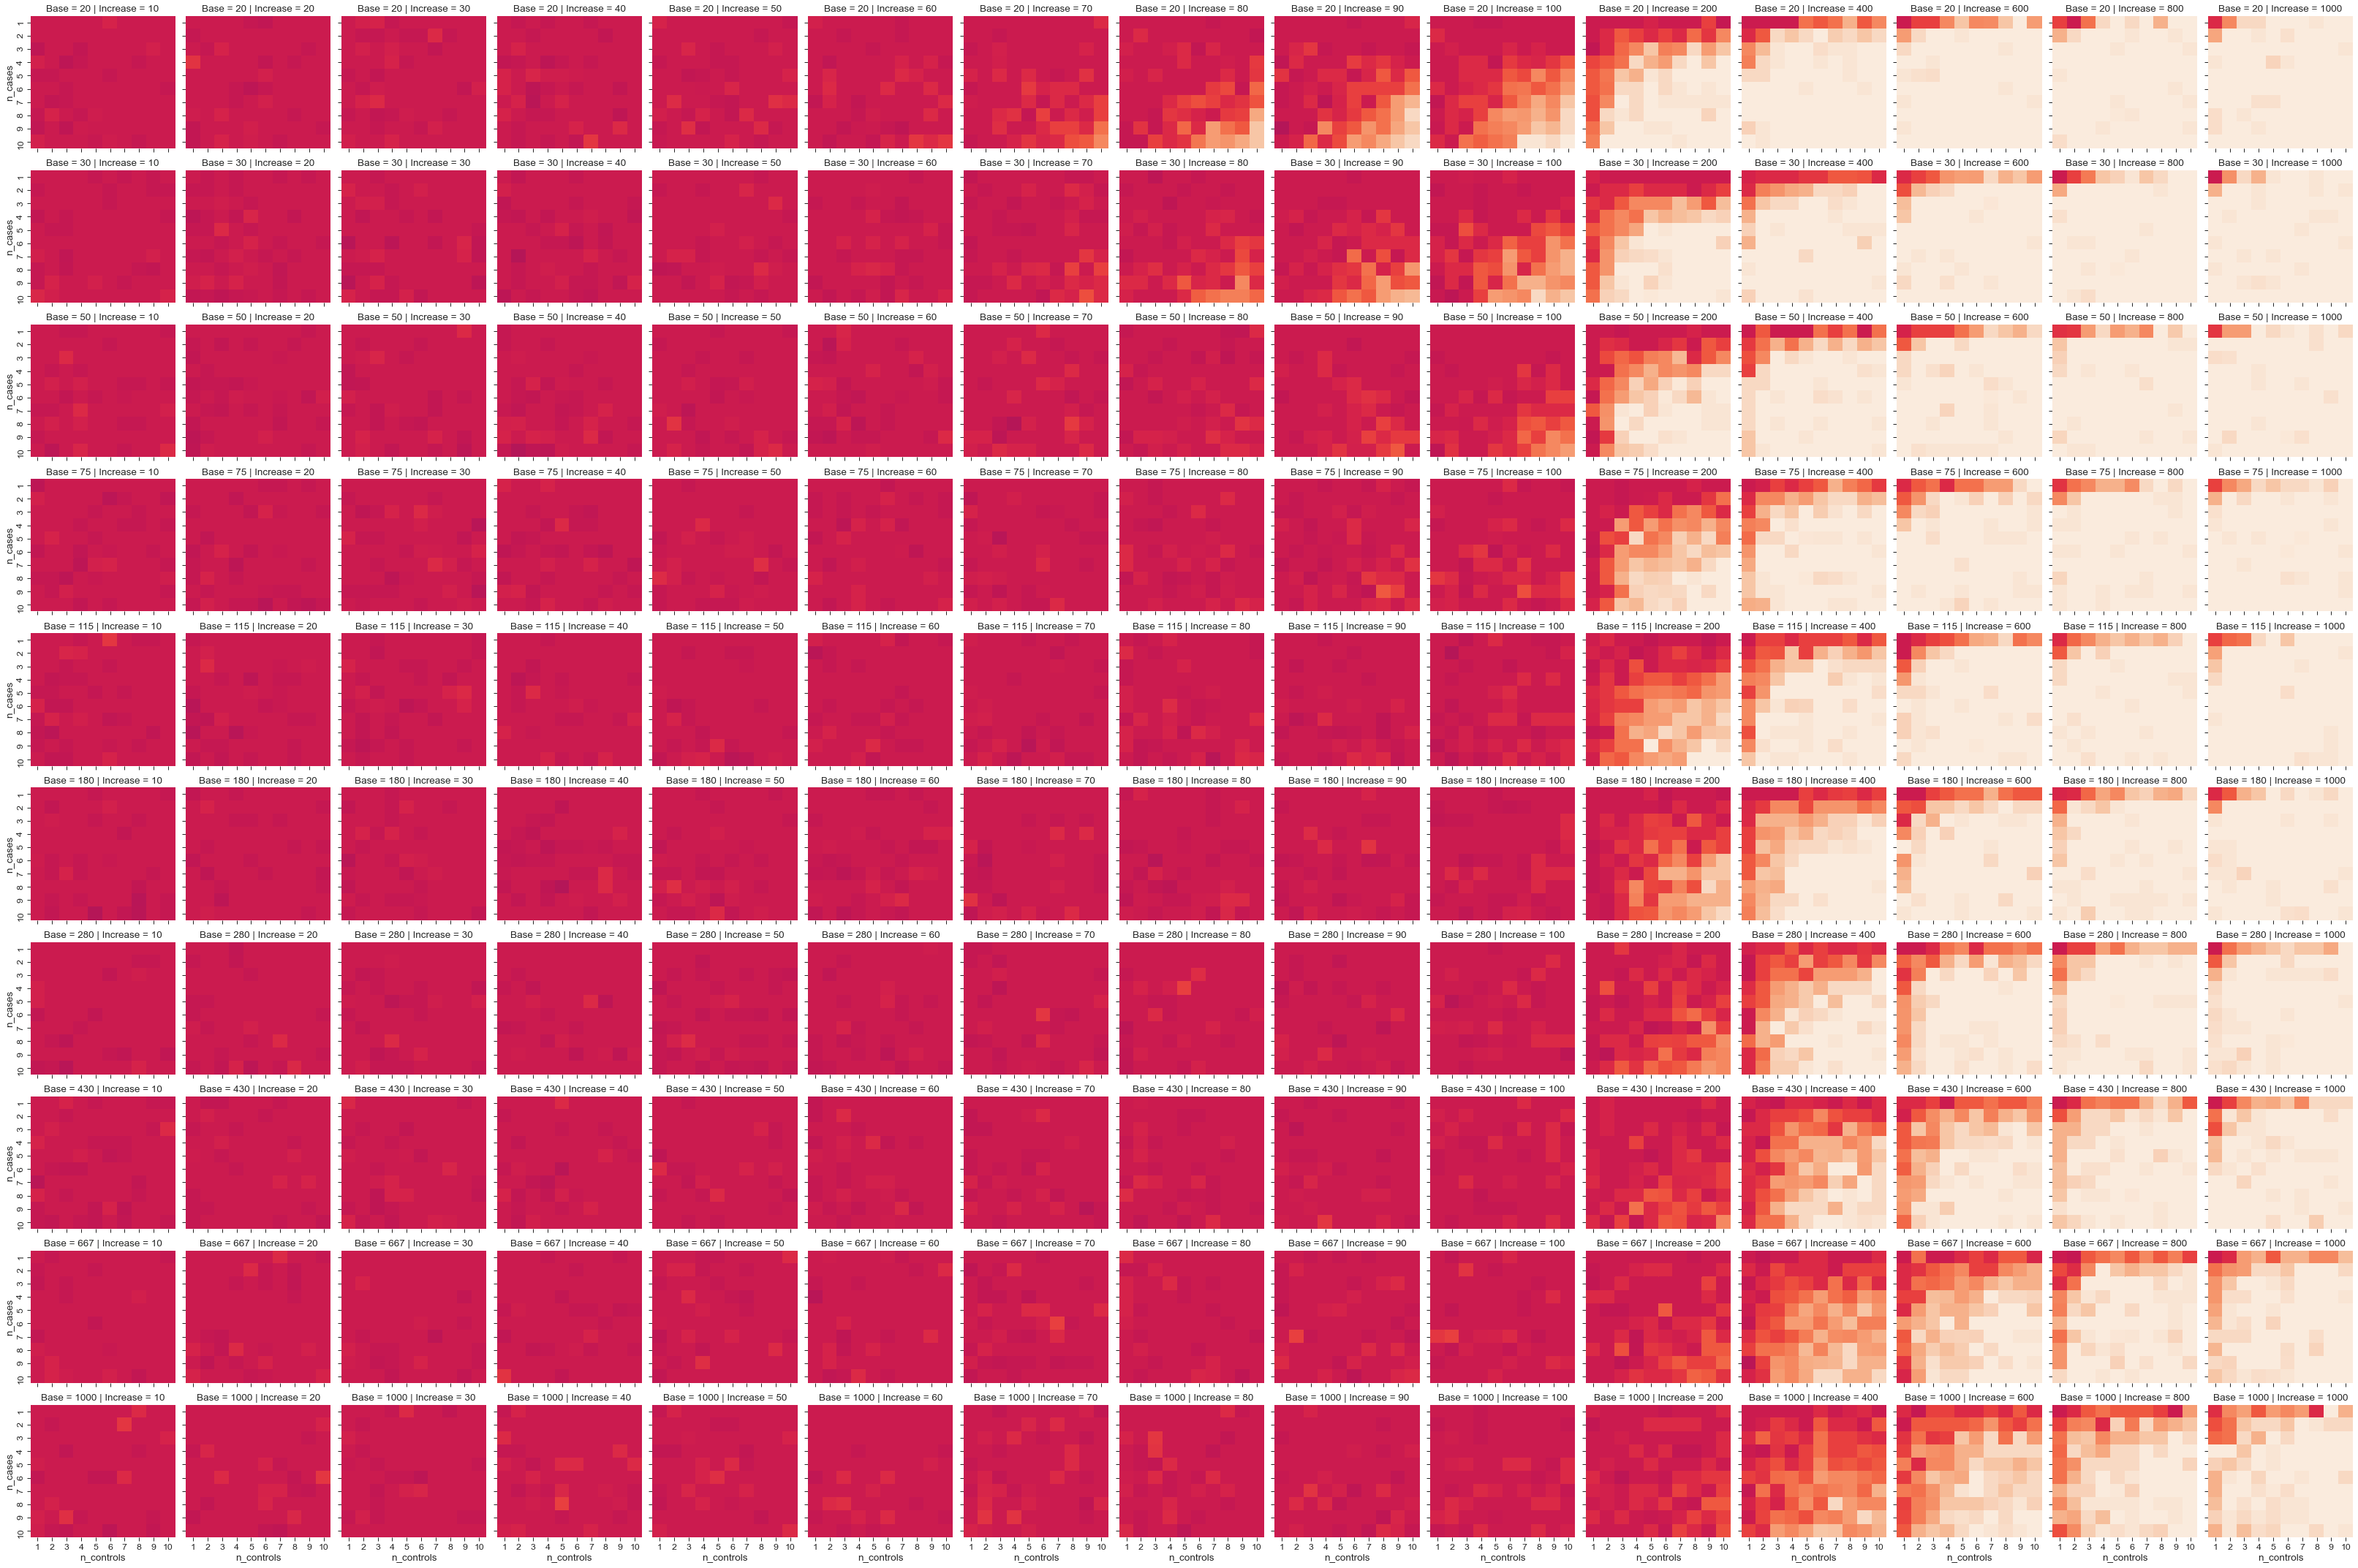

In [6]:
plot_path = "../../sccoda_benchmark_data_review/paper_plots_rv1/overall_benchmark_plots"

# Plot all heatmaps
res_grouped = res.groupby(["n_controls", "n_cases", "Base", "Increase"]).agg({"mcc": "mean"}).reset_index()

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs, vmin=-1, vmax=1)

fg = sns.FacetGrid(res_grouped, col='Increase', row="Base")
fg.map_dataframe(draw_heatmap, 'n_controls', 'n_cases', 'mcc', cbar=False)
# plt.savefig(plot_path + "/all_heatmaps.png")
plt.show()

Next, we plot one grid with a subselection for better readability.
These plots should serve are examples for the trends spotted in the complete heatmap grid above.

/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/Users/johannes.ostner/opt/anaconda3/envs/scCODA_2/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


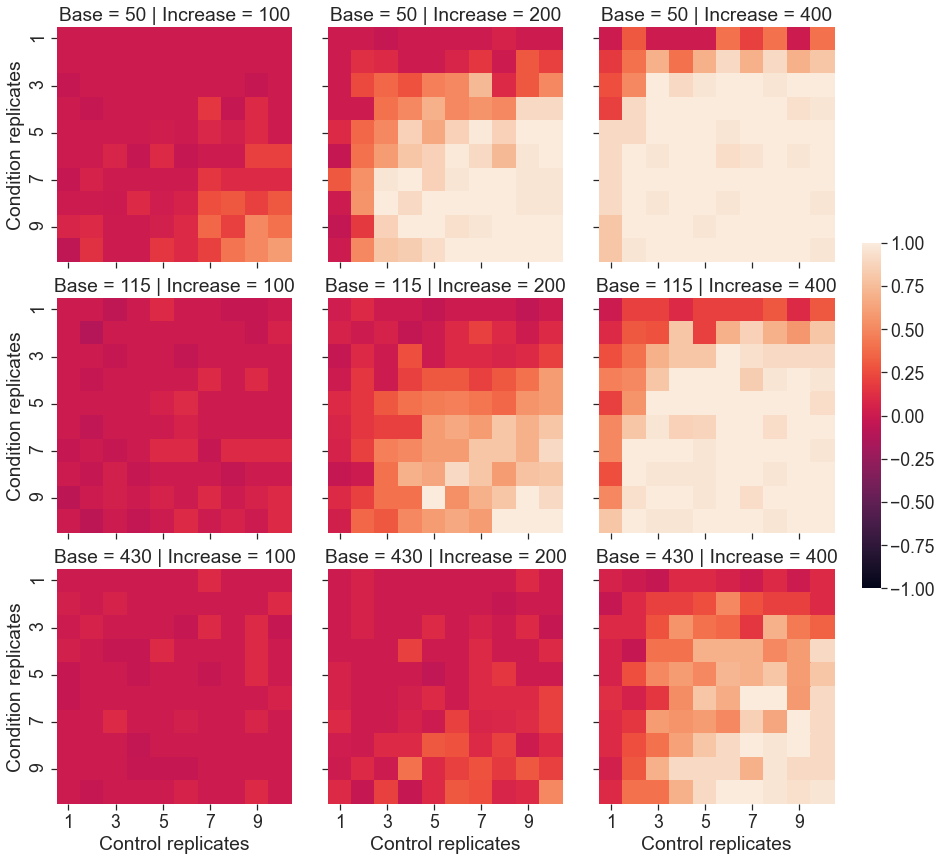

In [12]:
# plot heatmap subselection
base_counts = [50, 115, 430]
increases = [100, 200, 400]

paper_heatmaps_plot_df = res_grouped.loc[(res_grouped["Base"].isin(base_counts)) &
                                         (res_grouped["Increase"].isin(increases))]
sns.set(style="ticks", font_scale=1.6)

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    columns = kwargs.pop('columns')
    index = kwargs.pop('index')
    values = kwargs.pop('values')
    d = data.pivot(index=index, columns=columns, values=values)
    sns.heatmap(d, **kwargs)


fg = sns.FacetGrid(paper_heatmaps_plot_df, col='Increase', row="Base", height=3, aspect=1,
                   gridspec_kws={"right": 0.9, "left": 0.05, "top": 0.95, "bottom": 0.05, "wspace": 0.07, "hspace": 0.15},
                   )
cbar_ax = fg.fig.add_axes([.92, .3, .02, .4])
fg.map_dataframe(func=draw_heatmap, columns='n_controls', index='n_cases', values='mcc',
                 cbar_ax=cbar_ax, vmin=-1, vmax=1, square=True)

fg.fig.set_size_inches(13, 12)
for ax in fg.axes[2, :]:
    ax.set_xlabel('Control replicates')

for ax in fg.axes[:, 0]:
 ax.set_ylabel('Condition replicates')

# plt.savefig(plot_path + "/9_heatmaps_concept_fig.svg", format="svg")
# plt.savefig(plot_path + "/9_heatmaps_concept_fig.png", format="png")
plt.show()

Now, we plot the increase (absolute or log-fold) against the MCC, grouped by the base cell count of the effected cell type
In both plots we see different behaviour for different base counts,
indicating that neither the absolute, nor the log-fold increase alone can accurately predict the performance of scCODA.


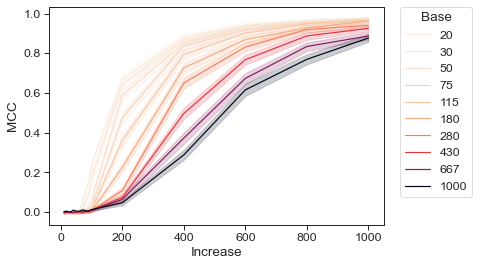

In [6]:
sns.set_context("paper", font_scale=1.4)

sns.lineplot(data=res,
             x="Increase", y="mcc", hue="Base",
             legend="full", palette=sns.cm.rocket_r
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Base")
plt.ylabel("MCC")
# plt.savefig(plot_path + "/absolute_increase_lines_concept_fig.svg", bbox_inches="tight", format="svg")
# plt.savefig(plot_path + "/absolute_increase_lines_concept_fig.png", bbox_inches="tight", format="png")

plt.show()

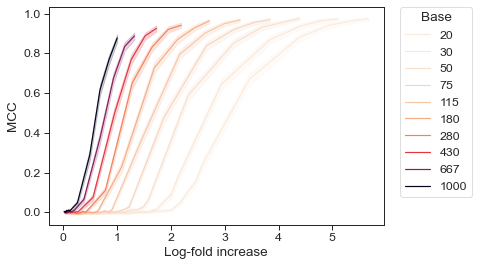

In [7]:
sns.lineplot(data=res,
             x="log-fold increase", y="mcc", hue="Base",
             legend="full", palette=sns.cm.rocket_r
             )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Base")
plt.xlabel("Log-fold increase")
plt.ylabel("MCC")

# plt.savefig(plot_path + "/log_fold_increase_lines_concept_fig.svg", bbox_inches="tight", format="svg")
# plt.savefig(plot_path + "/log_fold_increase_lines_concept_fig.png", bbox_inches="tight", format="png")

plt.show()
